In [30]:
import scipy.constants as const

# Pressure source - controls contributions to pressure
# Options: 'all', 'no_degeneracy', 'no_ideal_gas', 'no_radiation'
P_SOURCE = 'all'
assert P_SOURCE in ('all', 'no_degeneracy', 'no_ideal_gas', 'no_radiation'), 'Invalid pressure source chosen.'

# Parameter indices
IDX_DICT = {'rho': 0,'T': 1,'M': 2,'L': 3,'tau': 4}

pi = const.pi
G = const.G
c = const.c
k = const.k
sigma = 5.670373e-8
hbar = const.hbar
m_p = const.m_p
m_e = const.m_e
a = 4.0*sigma/c

M_sun = 1.98840987e+30
R_sun = 6.957e8
L_sun = 3.828e26

X = 0.73
Y = 0.25
Z = 0.02 
gamma = 5.0/3.0
Lambda = 0.0 #!
X_CNO = 0.03*X
mu = (2.0*X + 0.75*Y + 0.5*Z)**(-1)
kappa_es = 0.02*(1 + X)

# Numerical integration constants
H_MIN = 1e3
H_MAX_CORE_LOW_M = 5e6
H_MAX_CORE_HIGH_M = 5e5
H_MAX_OUTER = 5e4
H_MAX_SURF = 5e3
TOL_CORE = 1e-3
TOL_OUTER = 1e-5
TOL_SURF = 1e-7

# Solver bound constants
R_0 = 1.0
M_MAX = 1e3 * M_sun
R_MAX = 1e10 
DELTA_TAU_MIN = 1e-3

# Bisection constants
RHO_C_MIN = 2.5e2
RHO_C_MAX = 5.5e5
L_ERR_RANGE_MIN = 1e-3
L_ERR_MID_MIN = 1e-2
BISECTION_MAX = 50

# Plotting constants
DPI = 200

star equations

In [31]:
from numpy import zeros, log10

# Degeneracy pressure
def P_degen(rho):
    if P_SOURCE == 'no_degeneracy':
        return 0.0
    return (((3.0*(pi**2.0))**(2.0/3.0))*(hbar**2.0)*(rho**(5.0/3.0)))/(5.0*m_e*(m_p**(5.0/3.0)))

# Ideal gas pressure
def P_ideal(rho, T):
    if P_SOURCE == 'no_ideal_gas':
        return 0.0
    return (rho*k*T)/(mu*m_p)

# Radiation pressure
def P_rad(T):
    if P_SOURCE == 'no_radiation':
        return 0.0
    return (a*(T**4.0))/3.0

# Total pressure
def P(rho, T):
    return P_degen(rho) + P_ideal(rho, T) + P_rad(T)

# Derivative of degeneracy pressure with respect to density
def dPdrho_degen(rho):
    if P_SOURCE == 'no_degeneracy':
        return 0.0
    return (((3.0*(pi**2.0))**(2.0/3.0))*(hbar**2.0)*(rho**(2.0/3.0)))/(3.0*m_e*(m_p**(5.0/3.0)))

# Derivative of ideal gas pressure with respect to density
def dPdrho_ideal(T):
    if P_SOURCE == 'no_ideal_gas':
        return 0.0
    return (k*T)/(mu*m_p)

# Derivative of total pressure with respect to density
def dPdrho(rho, T):
    return dPdrho_degen(rho) + dPdrho_ideal(T)

# Derivative of ideal gas pressure with respect to temperature
def dPdT_ideal(rho):
    if P_SOURCE == 'no_ideal_gas':
        return 0.0
    return (rho*k)/(mu*m_p)

# Derivative of radiation pressure with respect to temperature
def dPdT_rad(T):
    if P_SOURCE == 'no_radiation':
        return 0.0
    return (4.0*a*(T**3.0))/3.0

# Derivative of total pressure with respect to temperature
def dPdT(rho, T):
    return dPdT_ideal(rho) + dPdT_rad(T)


# ----------------------------------------------------------------------------------------------------------------------


### OPACITY EQUATIONS ###
# Free-free opacity
def kappa_ff(rho, T):
    return 1.0e24 * (1.0 + X) * (Z + 0.0001) * ((rho/1e3)**0.7) * (T**(-3.5))

# H- opacity
def kappa_H(rho, T):
    return 2.5e-32 * (Z/0.02) * ((rho/1e3)**0.5) * (T**9.0)

# Total opacity
def kappa(rho, T):
    return ((1.0/kappa_H(rho, T)) + (1.0/max(kappa_es, kappa_ff(rho, T))))**(-1.0)


# ----------------------------------------------------------------------------------------------------------------------


### ENERGY GENERATION EQUATIONS ###
# PP-chain energy generation
def epsilon_PP(rho, T):
    return 1.07e-7 * (rho/1e5) * (X**2.0) * ((T/1e6)**4.0)

# CNO-chain energy generation
def epsilon_CNO(rho, T):
    return 8.24e-26 * (rho/1e5) * X_CNO * X * ((T / (1e6))**19.9)

# Total energy generation
def epsilon(rho, T):
    return epsilon_PP(rho, T) + epsilon_CNO(rho, T)


# ----------------------------------------------------------------------------------------------------------------------


### STELLAR STRUCTURE ODES ###
# Derivative of optical depth with respect to radius 
def dtaudr(rho, T):
    return kappa(rho, T) * rho

# Derivative of PP-luminosity with respect to radius
def dLdr_PP(r, rho, T):
    return 4.0 * pi * (r**2.0) * rho * epsilon_PP(rho, T)

# Derivative of CNO-luminosity with respect to radius
def dLdr_CNO(r, rho, T):
    return 4.0 * pi * (r**2.0) * rho * epsilon_CNO(rho, T)

# Derivative of total luminosity with respect to radius
def dLdr(r, rho, T):
    return 4.0 * pi * (r**2.0) * rho * epsilon(rho, T)

# Derivative of mass with respect to radius - dM/dr
def dMdr(r, rho):
    return 4.0 * pi * (r**2.0) * rho

# Derivative of radiative temperature with respect to radius
def dTdr_rad(r, rho, T, M, L):
    return (3.0*kappa(rho, T)*rho*L)/(64.0*pi*sigma*(T**3.0)*(r**2.0))
    
# Derivative of convective temperature with respect to radius  
def dTdr_conv(r, rho, T, M, L):
    return (1.0 - (1.0/gamma))*(1.0 + Lambda/r) * ((T*G*M*rho)/(P(rho, T)*(r**2.0)))

# Derivative of temperature with respect to radius
def dTdr(r, rho, T, M, L):
    return -min(abs(dTdr_rad(r, rho, T, M, L)), abs(dTdr_conv(r, rho, T, M, L)))

# Derivative of density with respect to radius
def drhodr(r, rho, T, M, L):
    return -((G*M*rho)/(r**2.0)*(1.0 + Lambda/r) + dPdT(rho, T)*dTdr(r, rho, T, M, L))/dPdrho(rho, T)


# ----------------------------------------------------------------------------------------------------------------------


### SYSTEM OF STELLAR STRUCTURE EQUATIONS ###
def stellar_structure_equations(r, u):
    rho = u[IDX_DICT["rho"]]
    T = u[IDX_DICT["T"]]
    M = u[IDX_DICT["M"]]
    L = u[IDX_DICT["L"]]

    drho = drhodr(r, rho, T, M, L)
    dT = dTdr(r, rho, T, M, L)
    dM = dMdr(r, rho)
    dL = dLdr(r, rho, T)
    dtau = dtaudr(rho, T)

    dudr = zeros(len(IDX_DICT))
    dudr[IDX_DICT["rho"]] = drho
    dudr[IDX_DICT["T"]] = dT
    dudr[IDX_DICT["M"]] = dM
    dudr[IDX_DICT["L"]] = dL
    dudr[IDX_DICT["tau"]] = dtau

    return dudr


# ----------------------------------------------------------------------------------------------------------------------

### INITIAL CONDITIONS ###
# Initial mass
def M_initial(r0, rho_c):
    return (4.0/3.0) * pi * (r0**3) * rho_c


# Initial luminosity
def L_initial(r0, rho_c, T_c):
    return (4.0/3.0) * pi * (r0**3) * rho_c * epsilon(rho_c, T_c)


# Initial optical depth
def tau_initial(r0, rho_c, T_c):
    return kappa(rho_c, T_c) * rho_c * r0


# ----------------------------------------------------------------------------------------------------------------------


# Derivative of logP with respect to logT - dlogP/dlogT
def dlogPdlogT(P, T):
    logP = log10(P)
    logT = log10(T)
    dlogP = [logP[i + 1] - logP[i] for i in range(len(P) - 1)]
    dlogT = [logT[i + 1] - logT[i] for i in range(len(T) - 1)]
    return [dlogP[i]/dlogT[i] for i in range(len(dlogP))]

# Finding index at which convection takes over
def get_conv_idx(dlogPdlogT_vals):
    conv_start = 0
    for idx in range(len(dlogPdlogT_vals)):
        if abs(dlogPdlogT_vals[idx] - 2.5) < 0.1:
            conv_start = idx
            break

    conv_end = 0
    for idx in range(conv_start, len(dlogPdlogT_vals)):
        if abs(dlogPdlogT_vals[idx] - 2.5) > 0.1:
            conv_end = idx - 1
            break
        
    if conv_end == 0:
        conv_end = -1

    return conv_start, conv_end


# ----------------------------------------------------------------------------------------------------------------------

adapted version of RK45

In [32]:
import numpy as np

def myRK4(system, r0, u0, h0, T_c):
    # Calculating slope coefficients
    k0 = h0 * system(r0, u0)
    k1 = h0 * system(r0 + 1/5*h0, u0 + 1/5*k0)
    k2 = h0 * system(r0 + 3/10*h0, u0 + 3/40*k0 + 9/40*k1)
    k3 = h0 * system(r0 + 4/5*h0, u0 + 44/45*k0 - 56/15*k1 + 32/9*k2)
    k4 = h0 * system(r0 + 8/9*h0, u0 + 19372/6561*k0 - 25360/2187*k1 + 64448/6561*k2 - 212/729*k3)
    k5 = h0 * system(r0 + h0, u0 + 9017/3168*k0 - 355/33*k1 + 46732/5247*k2 + 49/176*k3 - 5103/18656*k4)
    u_final = u0 + 35/384*k0 + 500/1113*k2 + 125/192*k3 - 2187/6784*k4 + 11/84*k5
    k6 = h0 * system(r0 + h0, u_final)

    # Determining fourth and fifth-order solutions
    u1_4 = u0 + 5179/57600*k0 + 7571/16695*k2 + 393/640*k3 - 92097/339200*k4 + 187/2100*k5 + 1/40*k6
    u1_5 = u_final

    # Relative error on solutions
    err = np.fabs(u1_5 - u1_4)

    # Stepsize and tolerance control
    h_min = H_MIN
    tol = TOL_CORE

    if T_c < 1.25e7:
        h_max = H_MAX_CORE_LOW_M

        if u1_5[IDX_DICT['T']]/T_c < 0.01:
            h_max = H_MAX_SURF
            tol = TOL_SURF

        elif u1_5[IDX_DICT['T']]/T_c < 0.05:
            h_max = H_MAX_OUTER
            tol = TOL_OUTER

    elif T_c >= 1.25e7:
        h_max = H_MAX_CORE_HIGH_M

        if u1_5[IDX_DICT['T']]/T_c < 0.005:
            h_max = H_MAX_SURF
            tol = TOL_SURF

        elif u1_5[IDX_DICT['T']]/T_c < 0.025:
            h_max = H_MAX_OUTER
            tol = TOL_OUTER

    # Stepsize update
    no_zero_div = err==0
    s = ((np.fabs(u1_5)*tol)/(2*(err + no_zero_div)))**(1/5)
    h1 = h0 * np.min(s)
    h1 = min(max(h1, h_min), h_max)

    return h1, u1_5

solving star equations

In [33]:
import numpy as np

# Gets solution values at a given solution iteration
def get_u0(star_params, idx):
    u0 = [0.0]*len(IDX_DICT)
    for param in IDX_DICT:
        u0[IDX_DICT[param]] = star_params[param][idx]
    return np.array(u0, float)

# Gets all stellar parameter values at a given solution iteration
def get_step_params(star_params, idx):
    return {param: star_params[param][idx] for param in star_params}

# Updates the values of all stellar parameters
def update_params(star_params, u1):
    for param in IDX_DICT:
            star_params[param].append(u1[IDX_DICT[param]])

    r = star_params['r'][-1]
    rho = u1[IDX_DICT['rho']]
    T = u1[IDX_DICT['T']]
    M = u1[IDX_DICT['M']]
    L = u1[IDX_DICT['L']]

    star_params['P_degen'].append(P_degen(rho))
    star_params['P_ideal'].append(P_ideal(rho, T))
    star_params['P_rad'].append(P_rad(T))
    star_params['P'].append(P(rho, T))
    star_params['epsilon_PP'].append(epsilon_PP(rho, T))
    star_params['epsilon_CNO'].append(epsilon_CNO(rho, T))
    star_params['epsilon'].append(epsilon(rho, T))
    star_params['dL_PP/dr'].append(dLdr_PP(r, rho, T))
    star_params['dL_CNO/dr'].append(dLdr_CNO(r, rho, T))
    star_params['dL/dr'].append(dLdr(r, rho, T))
    star_params['kappa_ff'].append(kappa_ff(rho, T))
    star_params['kappa_H'].append(kappa_H(rho, T))
    star_params['kappa'].append(kappa(rho, T))


# ----------------------------------------------------------------------------------------------------------------------


### FINDING STAR SURFACE ###
# Determines if tau = tau(inf)
def at_tau_inf(step_params):
    r = step_params['r']
    rho = step_params['rho']
    T = step_params['T']
    M = step_params['M']
    L = step_params['L']

    drho = drhodr(r, rho, T, M, L)
    delta_tau = (kappa(rho, T)*rho**2)/np.fabs(drho)
    if (np.isnan(drho)) or ((drho != 0) and (delta_tau < DELTA_TAU_MIN)):
        return True
    else:
        return False

# Gets index of star surface
def get_surf_idx(tau_vals):
    tau_inf_idx = len(tau_vals) - 1
    if np.isnan(tau_vals[tau_inf_idx]):
        tau_inf_idx = len(tau_vals) - 2
    tau_inf = tau_vals[tau_inf_idx]

    tau_boundary_cond = tau_inf - np.array(tau_vals[0:tau_inf_idx]) - (2.0/3.0)
    surf_idx = np.argmin(np.abs(tau_boundary_cond))

    if surf_idx == 0:
        return tau_inf_idx
    else:
        return surf_idx

# Gets parameters at star surface
def get_surf_params(star_params):
    surf_idx = get_surf_idx(star_params['tau'])
    surf_params = get_step_params(star_params, surf_idx)
    return surf_params, surf_idx


# ----------------------------------------------------------------------------------------------------------------------


### SOLVING STELLAR STRUCTURE EQUATIONS ###
def solve_stellar_structure(rho_c, T_c):
    star_params = {
        'r': [R_0],
        'rho': [rho_c],
        'T': [T_c],
        'M': [M_initial(R_0, rho_c)],
        'L': [L_initial(R_0, rho_c, T_c)],
        'tau': [tau_initial(R_0, rho_c, T_c)],
        'P_degen': [P_degen(rho_c)],
        'P_ideal': [P_ideal(rho_c, T_c)],
        'P_rad': [P_rad(T_c)],
        'P': [P(rho_c, T_c)],
        'epsilon_PP': [epsilon_PP(rho_c, T_c)],
        'epsilon_CNO': [epsilon_CNO(rho_c, T_c)],
        'epsilon': [epsilon(rho_c, T_c)],
        'dL_PP/dr': [dLdr_PP(R_0, rho_c, T_c)],
        'dL_CNO/dr': [dLdr_CNO(R_0, rho_c, T_c)],
        'dL/dr': [dLdr(R_0, rho_c, T_c)],
        'kappa_ff': [kappa_ff(rho_c, T_c)],
        'kappa_H': [kappa_H(rho_c, T_c)],
        'kappa': [kappa(rho_c, T_c)]}

    h = 1e4
    step_count = 1 
    step_params = get_step_params(star_params, step_count - 1)

    while (step_params['r'] < R_MAX) and (step_params['M'] < M_MAX) and (not at_tau_inf(step_params)):
        star_params['r'].append(step_params['r'] + h)
        u0 = get_u0(star_params, step_count - 1)
        h, u1 = myRK4(stellar_structure_equations, step_params['r'], u0, h, T_c)

        update_params(star_params, u1)

        step_count += 1
        step_params = get_step_params(star_params, step_count - 1)

    surf_params, surf_idx = get_surf_params(star_params)
    for param in star_params:
        star_params[param] = np.array(star_params[param][:surf_idx])

    return star_params

# ---------------------------------------------------------------------------------------------------------------------- 

Bisection method

In [34]:
### BISECTION ###
# Determining the error in luminosity
def L_err(star_params):
    surf_params, surf_idx = get_surf_params(star_params)
    R_surf = surf_params['r']
    T_surf = surf_params['T']
    L_surf = surf_params['L']

    L_obs = L_surf
    L_exp = 4.0 * pi * sigma * (R_surf**2.0) * (T_surf**4.0)
    return (L_obs - L_exp)/np.sqrt(L_obs * L_exp)

# Implementing bisection
def bisection(T_c):
    min_params = solve_stellar_structure(RHO_C_MIN, T_c)
    max_params = solve_stellar_structure(RHO_C_MAX, T_c)

    rho_c_mid = (RHO_C_MIN + RHO_C_MAX)/2
    mid_params = solve_stellar_structure(rho_c_mid, T_c)
    
    bisection_count = 0
    range_err = min_params['rho'][0] - max_params['rho'][0]
    mid_err = L_err(mid_params)

    #print('-'*80)
    #print(f'Determining stellar structure for T_c = {T_c} K...')
    #print('-'*80)
    while (abs(range_err) > L_ERR_RANGE_MIN) and (abs(mid_err) > L_ERR_MID_MIN) and (bisection_count < BISECTION_MAX):

        extra_zeros = (len(str(BISECTION_MAX)) - len(str(bisection_count + 1)))*'0'
        #print(f'[Bisection {extra_zeros + str(bisection_count + 1)} | T_c = {T_c} K]')
        #print(f'- Luminosity error = {mid_err}')
        #print(f'- rho_c = {mid_params["rho"][0]} kg/m^3')

        if np.isnan(mid_err) or mid_err > 0:
            max_params = mid_params
        elif mid_err < 0:
            min_params = mid_params

        rho_c_mid = (min_params['rho'][0] + max_params['rho'][0])/2
        mid_params = solve_stellar_structure(rho_c_mid, T_c)

        bisection_count += 1
        range_err = min_params['rho'][0] - max_params['rho'][0]
        mid_err = L_err(mid_params)

    min_err = L_err(min_params)
    max_err = L_err(max_params)

    if (abs(mid_err) > L_ERR_MID_MIN) and (abs(max_err) < abs(mid_err)) and (abs(max_err) < abs(min_err)):
        mid_params = max_params
    elif (abs(mid_err) > L_ERR_MID_MIN) and (abs(min_err) < abs(mid_err)) and (abs(min_err) < abs(max_err)):
        mid_params = min_params

    final_err = L_err(mid_params)
    rho_c = mid_params['rho'][0]
    surf_params, surf_idx = get_surf_params(mid_params)

    star_params = mid_params
    for param in star_params:
        star_params[param] = np.array(star_params[param][:surf_idx + 1])

    r_surf = surf_params["r"]
    M_surf = surf_params["M"]
    L_surf = surf_params["L"]
    T_comp = surf_params["T"]
    T_corr = (L_surf/(4.0 * pi * (r_surf**2) * sigma))**(1.0/4.0)

    #print('-'*80)
    print(f'Bisection results for T_c = {T_c} K:')
    print(f'- Steps taken: {bisection_count}')
    print(f'- Final luminosity error: {final_err}')
    print(f'- R = {r_surf/R_sun} R_sun ({r_surf} m)')
    print(f'- M = {M_surf/M_sun} M_sun ({M_surf} kg)')
    print(f'- L = {L_surf/L_sun} L_sun ({L_surf} W)')
    print(f'- Computed T = {T_comp} K')
    print(f'- Corrected T = {T_corr} K')
    print(f'- rho_c = {rho_c} kg/m^3')
    print('-'*80)
    
    return surf_params, star_params


Ploting...

In [35]:
import matplotlib.pyplot as plt

In [36]:
def plot_main_structure(r_vals, rho_vals, T_vals, M_vals, L_vals, conv_idx, T_c, res_path):
    ax = sns.lineplot(x=r_vals, y=rho_vals, label=r'$\rho$')
    ax = sns.lineplot(x=r_vals, y=T_vals, label=r'$T$')
    ax = sns.lineplot(x=r_vals, y=M_vals, label=r'$M$')
    ax = sns.lineplot(x=r_vals, y=L_vals, label=r'$L$')
    plt.xlim([0,1])
    ax.axvspan(r_vals[conv_idx[0]], r_vals[conv_idx[1]], alpha=0.5)
    ax.set_xlabel(r'$r/R_{\mathrm{star}}$')
    ax.set_ylabel(r'$\rho/\rho_c, \;\; T/T_c, \;\; M/M_{\mathrm{star}}, \;\; L/L_{\mathrm{star}}$')
    ax.legend(loc='best')
    plt.savefig(res_path + '/structure.png', dpi=DPI)
    plt.show()

# Plotting optical depth
def plot_tau(r_vals, tau_vals, conv_idx, T_c, res_path):
    ax = sns.lineplot(x=r_vals, y=tau_vals)
    ax.axvspan(r_vals[conv_idx[0]], r_vals[conv_idx[1]], alpha=0.5)
    ax.set_xlabel(r'$r/R_{\mathrm{star}}$')
    ax.set_ylabel(r'$\tau$')
    plt.xlim([0,1])
    plt.savefig(res_path + '/tau.png', dpi=DPI)
    plt.show()

# Plotting pressure
def plot_P(r_vals, P_degen_vals, P_ideal_vals, P_rad_vals, P_vals, conv_idx, T_c, res_path):
    ax = sns.lineplot(x=r_vals, y=P_vals, label=r'$P_{\mathrm{total}}$')
    ax = sns.lineplot(x=r_vals, y=P_degen_vals, ls='-.', label=r'$P_{\mathrm{deg}}$')
    ax = sns.lineplot(x=r_vals, y=P_ideal_vals, ls='--', label=r'$P_{\mathrm{ideal}}$')
    ax = sns.lineplot(x=r_vals, y=P_rad_vals, ls=':', label=r'$P_{\mathrm{rad}}$')
    ax.axvspan(r_vals[conv_idx[0]], r_vals[conv_idx[1]], alpha=0.5)
    ax.set_xlabel(r'$r/R_{\mathrm{star}}$')
    ax.set_ylabel(r'$P/P_c$')
    plt.xlim([0,1])
    ax.legend(loc='best')
    plt.savefig(res_path + '/pressure.png', dpi=DPI)
    plt.show()

# Plotting dlogP/dlogT
def plot_dlogPdlogT(r_vals, dlogPdlogT_vals, conv_idx, T_c, res_path):
    ax = sns.lineplot(x=r_vals[:-1], y=dlogPdlogT_vals,)
    ax.axvspan(r_vals[conv_idx[0]], r_vals[conv_idx[1]], alpha=0.5)
    ax.set_xlabel(r'$r/R_{\mathrm{star}}$')
    ax.set_ylabel(r'$\mathrm{d}\log{P}/\mathrm{d}\log{T}$')
    plt.xlim([0,1])
    plt.savefig(res_path + '/dlogPdlogT.png', dpi=DPI)
    plt.show()

# Plotting energy generation
def plot_epsilon(r_vals, epsilon_PP_vals, epsilon_CNO_vals, epsilon_vals, conv_idx, T_c, res_path):
    ax = sns.lineplot(x=r_vals, y=epsilon_vals, label=r'$\epsilon$')
    ax = sns.lineplot(x=r_vals, y=epsilon_PP_vals, ls='--', label=r'$\epsilon_{\mathrm{PP}}$')
    ax = sns.lineplot(x=r_vals, y=epsilon_CNO_vals, ls='-.', label=r'$\epsilon_{\mathrm{CNO}}$')
    ax.axvspan(r_vals[conv_idx[0]], r_vals[conv_idx[1]], alpha=0.5)
    ax.set_xlabel(r'$r/R_{\mathrm{star}}$')
    ax.set_ylabel(r'$\epsilon \;\; (\mathrm{W/kg})$')
    ax.legend(loc='best')
    plt.xlim([0,1])
    plt.savefig(res_path + '/epsilon.png', dpi=DPI)
    plt.show()

# Plotting change in luminosity with radius
def plot_dLdr(r_vals, dLdr_PP_vals, dLdr_CNO_vals, dLdr_vals, conv_idx, T_c, res_path):
    ax = sns.lineplot(x=r_vals, y=dLdr_vals, label=r'$\mathrm{d}L/\mathrm{d}r$')
    ax = sns.lineplot(x=r_vals, y=dLdr_PP_vals, ls='--', label=r'$\mathrm{d}L_{\mathrm{PP}}/\mathrm{d}r$')
    ax = sns.lineplot(x=r_vals, y=dLdr_CNO_vals, ls='-.', label=r'$\mathrm{d}L_{\mathrm{CNO}}/\mathrm{d}r$')
    ax.axvspan(r_vals[conv_idx[0]], r_vals[conv_idx[1]], alpha=0.5)
    ax.set_xlabel(r'$r/R_{\mathrm{star}}$')
    ax.set_ylabel(r'$\mathrm{d}L/\mathrm{d}r \;\; (\mathrm{W/m})$')
    ax.legend(loc='best')
    plt.xlim([0,1])
    plt.savefig(res_path + '/dLdr.png', dpi=DPI)
    plt.show()

# Plotting opacity
def plot_kappa(r_vals, kappa_es_vals, kappa_ff_vals, kappa_H_vals, kappa_vals, conv_idx, T_c, res_path):
    # Plotting only the total kappa value
    ax1 = sns.lineplot(x=r_vals, y=kappa_vals,)
    ax1.axvspan(r_vals[conv_idx[0]], r_vals[conv_idx[1]], alpha=0.5)
    ax1.set_xlabel(r'$r/R_{\mathrm{star}}$')
    ax1.set_ylabel(r'$\log_{10}(\kappa) \;\; (\mathrm{m}^2\mathrm{/kg})$')
    plt.xlim([0,1])
    plt.savefig(res_path + '/kappa_main.png', dpi=DPI)
    plt.show()

    # Plotting all kappa values
    ax2 = sns.lineplot(x=r_vals, y=kappa_vals, label=r'$\kappa$')
    ax2 = sns.lineplot(x=r_vals, y=kappa_es_vals, ls=':', label=r'$\kappa_{\mathrm{es}}$')
    ax2 = sns.lineplot(x=r_vals, y=kappa_ff_vals, ls='--', label=r'$\kappa_{\mathrm{ff}}$')
    ax2 = sns.lineplot(x=r_vals, y=kappa_H_vals, ls='-.', label=r'$\kappa_{\mathrm{H}^-}$')
    ax2.axvspan(r_vals[conv_idx[0]], r_vals[conv_idx[1]], alpha=0.5)
    ax2.set_xlabel(r'$r/R_{\mathrm{star}}$')
    ax2.set_ylabel(r'$\log_{10}(\kappa) \;\; (\mathrm{m}^2\mathrm{/kg})$')
    ax2.legend(loc='best')
    plt.xlim([0,1])
    plt.savefig(res_path + '/kappa_all.png', dpi=DPI)
    plt.show()


# ----------------------------------------------------------------------------------------------------------------------


### PLOTTING STAR PARAMETER VALUES ###
def plot_star_params(T_c, res_path):
    # Getting structure values
    surf_params, star_params = bisection(T_c)
    r_surf = surf_params['r']
    rho_c = star_params['rho'][0]
    T_surf = surf_params['T']
    M_surf = surf_params['M']
    L_surf = surf_params['L']
    P_c = star_params['P'][0]

    r_vals = star_params['r']
    rho_vals = star_params['rho']
    T_vals = star_params['T']
    M_vals = star_params['M']
    L_vals = star_params['L']
    tau_vals = star_params['tau']
    P_degen_vals = star_params['P_degen']
    P_ideal_vals = star_params['P_ideal']
    P_rad_vals = star_params['P_rad']
    P_vals = star_params['P']
    epsilon_PP_vals = star_params['epsilon_PP']
    epsilon_CNO_vals = star_params['epsilon_CNO']
    epsilon_vals = star_params['epsilon']
    dLdr_PP_vals = star_params['dL_PP/dr']
    dLdr_CNO_vals = star_params['dL_CNO/dr']
    dLdr_vals = star_params['dL/dr']
    kappa_ff_vals = star_params['kappa_ff']
    kappa_H_vals = star_params['kappa_H']
    kappa_vals = star_params['kappa']

    dlogPdlogT_vals = np.array(dlogPdlogT(P_vals, T_vals))
    conv_idx = get_conv_idx(dlogPdlogT_vals)

    # Calculating plotting values
    scaled_r = r_vals/r_surf
    scaled_rho = rho_vals/rho_c
    scaled_T = T_vals/T_c
    scaled_M = M_vals/M_surf
    scaled_L = L_vals/L_surf
    scaled_P_degen = P_degen_vals/P_c
    scaled_P_ideal = P_ideal_vals/P_c
    scaled_P_rad = P_rad_vals/P_c
    scaled_P = P_vals/P_c
    log_kappa = np.log10(kappa_vals)
    log_kappa_es = np.log10(kappa_es * np.ones_like(kappa_vals))
    log_kappa_ff = np.log10(kappa_ff_vals)
    log_kappa_H = np.log10(kappa_H_vals)

    # Plotting results
    print('Plotting stellar parameters...')
    print('-'*80)
    plot_main_structure(scaled_r, scaled_rho, scaled_T, scaled_M, scaled_L, conv_idx, T_c, res_path)
    print('Plotted rho, T, M, L vs. r')
    plot_tau(scaled_r, tau_vals, conv_idx, T_c, res_path)
    print('Plotted tau vs. r')
    plot_P(scaled_r, scaled_P_degen, scaled_P_ideal, scaled_P_rad, scaled_P, conv_idx, T_c, res_path)
    print('Plotted P vs. r')
    plot_dlogPdlogT(scaled_r, dlogPdlogT_vals, conv_idx, T_c, res_path)
    print('Plotted dlogP/dlogT vs. r')
    plot_epsilon(scaled_r, epsilon_PP_vals, epsilon_CNO_vals, epsilon_vals, conv_idx, T_c, res_path)
    print('Plotted epsilon vs. r')
    plot_dLdr(scaled_r, dLdr_PP_vals, dLdr_CNO_vals, dLdr_vals, conv_idx, T_c, res_path)
    print('Plotted dL/dr vs. r')
    plot_kappa(scaled_r, log_kappa_es, log_kappa_ff, log_kappa_H, log_kappa, conv_idx, T_c, res_path)
    print('Plotted kappa vs. r')
    print('-'*80)
    print('Plotting complete.')

    """
    # Saving star parameters
    print('Saving results...')
    with open(res_path + '/star_params.txt', 'w') as f:
        f.write(f'T_c = {T_c} K\n')
        f.write(f'rho_c = {rho_c} kg/m^3\n')
        f.write(f'R = {r_surf/R_sun} R_sun\n')
        f.write(f'M = {M_surf/M_sun} M_sun\n')
        f.write(f'L = {L_surf/L_sun} L_sun\n')
        f.write(f'T_calc = {T_surf} K\n')
        f.write(f'T_corr = {(L_surf/(4.0 * pi * (r_surf**2) * sigma))**(1.0/4.0)} K')
    f.close()
    print('Results saved.')
    print('-'*80)
    """
    
# ----------------------------------------------------------------------------------------------------------------------

In [37]:
import seaborn as sns
from joblib import Parallel, delayed
import numpy as np


In [38]:
# MAIN SEQUENCE PLOTS

# Plotting luminosity vs. temperature
def plot_L_vs_T(T_vals, L_vals, res_path, from_data):
    plt.scatter(T_vals, L_vals, marker='o')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$T \;\; (\mathrm{K})$')
    plt.ylabel(r'$L/L_{\odot}$')
    plt.gca().invert_xaxis()
    if from_data:
        plt.savefig(res_path + '/HR_diagram_from_data.png', dpi=DPI)
    else:
        plt.savefig(res_path + '/HR_diagram.png', dpi=DPI)
    plt.show()

# Plotting luminosity vs. mass
def plot_L_vs_M(M_vals, L_vals, res_path, from_data):
    plt.scatter(M_vals, L_vals, marker='o')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$M/M_{\odot}$')
    plt.ylabel(r'$L/L_{\odot}$')
    if from_data:
        plt.savefig(res_path + '/M_L_relation_from_data.png', dpi=DPI)
    else:
        plt.savefig(res_path + '/M_L_relation.png', dpi=DPI)
    plt.show()


# Plotting radius vs. mass
def plot_R_vs_M(M_vals, R_vals, res_path, from_data):
    plt.scatter(M_vals, R_vals, marker='o')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$M/M_{\odot}$',)
    plt.ylabel(r'$R/R_{\odot}$')
    if from_data:
        plt.savefig(res_path + '/M_R_relation_from_data.png', dpi=DPI)
    else:
        plt.savefig(res_path + '/M_R_relation.png', dpi=DPI)
    plt.show()


# ----------------------------------------------------------------------------------------------------------------------
### PLOTTING MAIN SEQUENCE ###
# Plotting the main sequence using the stellar structure solver
def main_sequence_vals(T_c):
    surf_params, star_params = bisection(T_c)
    rho_c = star_params['rho'][0]
    R = surf_params['r']
    M = surf_params['M']
    L = surf_params['L']
    T = (L/(4.0 * pi * (R**2) * sigma))**(1.0/4.0)
    return rho_c, R, T, M, L

def plot_main_sequence(T_c_min, T_c_max, N, res_path):
    # Calculating main sequence values
    T_c_vals = np.linspace(T_c_min, T_c_max, N)
    main_sequence = np.array(Parallel(n_jobs=4)(delayed(main_sequence_vals)(T_c) for T_c in T_c_vals))
    rho_c_vals = main_sequence[:,0]
    R_vals = main_sequence[:,1]/R_sun
    T_vals = main_sequence[:,2]
    M_vals = main_sequence[:,3]/M_sun
    L_vals = main_sequence[:,4]/L_sun

    # Plotting results
    print('Plotting main sequence...')
    print('-'*80)
    plot_L_vs_T(T_vals, L_vals, res_path, False)
    print('Plotted Hertzsprung-Russell diagram')
    plot_L_vs_M(M_vals, L_vals, res_path, False)
    print('Plotted mass-luminosity relation')
    plot_R_vs_M(M_vals, R_vals, res_path, False)
    print('Plotted mass-radius relation')
    print('-'*80)
    print('Plotting complete.')

    # Saving results
    print('Saving results...')
    with open(res_path + '/main_sequence_values.txt', 'w') as f:
        f.write('T_c rho_c R T M L\n')
        for i in range(len(T_c_vals)):
            f.write(f'{T_c_vals[i]} {rho_c_vals[i]} {R_vals[i]} {T_vals[i]} {M_vals[i]} {L_vals[i]}\n')
    f.close()
    print('Results saved.')
    print('-'*80)
# ----------------------------------------------------------------------------------------------------------------------

Plotting main sequence...
--------------------------------------------------------------------------------


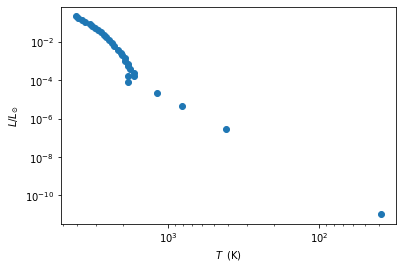

Plotted Hertzsprung-Russell diagram


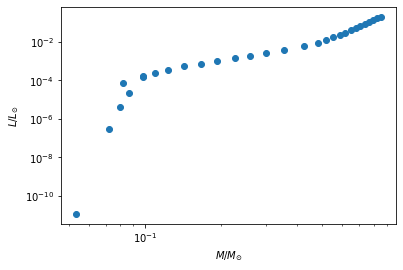

Plotted mass-luminosity relation


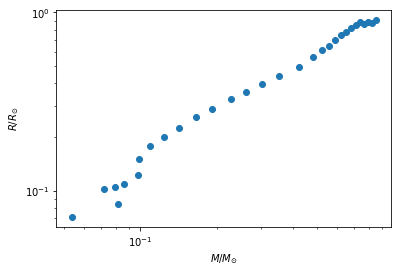

Plotted mass-radius relation
--------------------------------------------------------------------------------
Plotting complete.
Saving results...
Results saved.
--------------------------------------------------------------------------------


In [39]:
Lambda = 0
plot_main_sequence(30000, 1e7, 30, 'MS')

Plotting main sequence...
--------------------------------------------------------------------------------


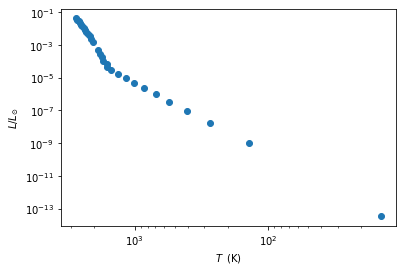

Plotted Hertzsprung-Russell diagram


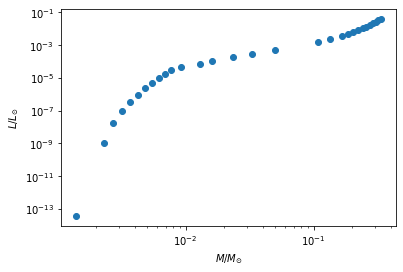

Plotted mass-luminosity relation


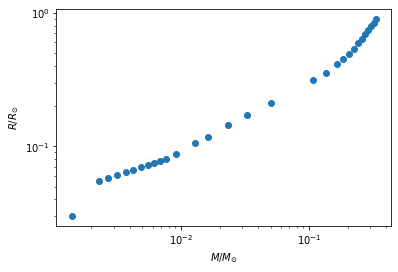

Plotted mass-radius relation
--------------------------------------------------------------------------------
Plotting complete.
Saving results...
Results saved.
--------------------------------------------------------------------------------


In [41]:
Lambda = 1e8
plot_main_sequence(30000, 1e7, 30, 'MS_pos')

Plotting main sequence...
--------------------------------------------------------------------------------


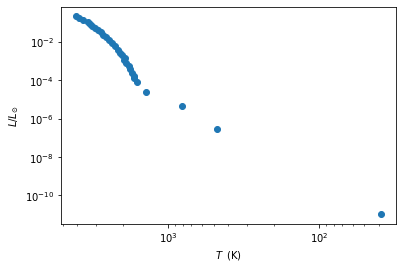

Plotted Hertzsprung-Russell diagram


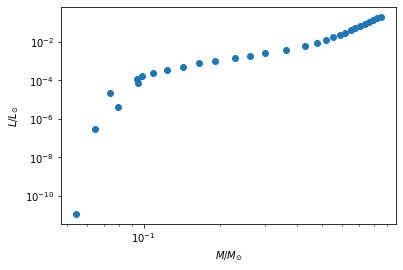

Plotted mass-luminosity relation


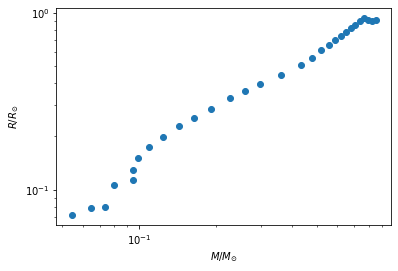

Plotted mass-radius relation
--------------------------------------------------------------------------------
Plotting complete.
Saving results...
Results saved.
--------------------------------------------------------------------------------


In [45]:
Lambda = -1e4
plot_main_sequence(30000, 1e7, 30, 'MS_neg_e4')

Plotting main sequence...
--------------------------------------------------------------------------------


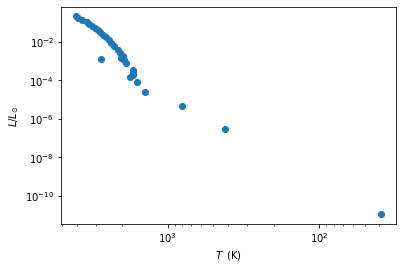

Plotted Hertzsprung-Russell diagram


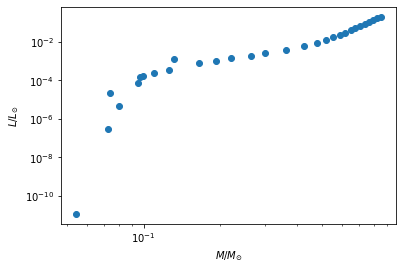

Plotted mass-luminosity relation


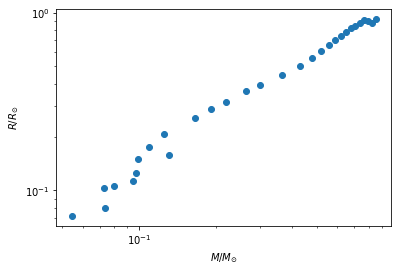

Plotted mass-radius relation
--------------------------------------------------------------------------------
Plotting complete.
Saving results...
Results saved.
--------------------------------------------------------------------------------


In [47]:
Lambda = -1e5
plot_main_sequence(30000, 1e7, 30, 'MS_neg_e5')

Plotting main sequence...
--------------------------------------------------------------------------------


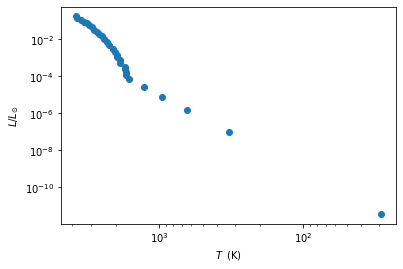

Plotted Hertzsprung-Russell diagram


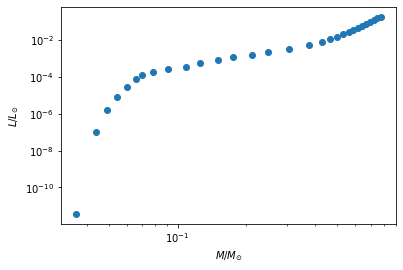

Plotted mass-luminosity relation


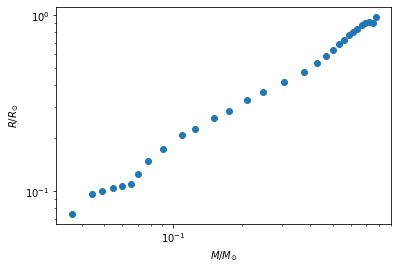

Plotted mass-radius relation
--------------------------------------------------------------------------------
Plotting complete.
Saving results...
Results saved.
--------------------------------------------------------------------------------


In [49]:
Lambda = 1e7
plot_main_sequence(30000, 1e7, 30, 'MS_pos_e7')

Plotting main sequence...
--------------------------------------------------------------------------------


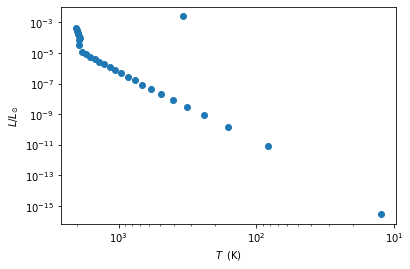

Plotted Hertzsprung-Russell diagram


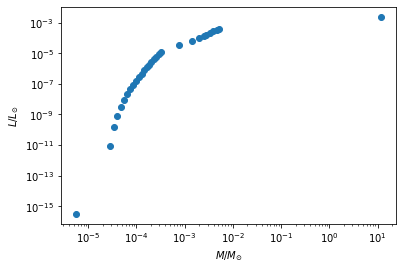

Plotted mass-luminosity relation


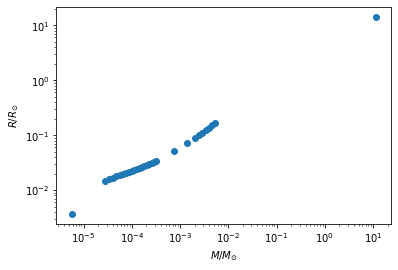

Plotted mass-radius relation
--------------------------------------------------------------------------------
Plotting complete.
Saving results...
Results saved.
--------------------------------------------------------------------------------


In [50]:
Lambda = 5e8
plot_main_sequence(30000, 1e7, 30, 'MS_pos_5e8')

Plotting main sequence...
--------------------------------------------------------------------------------


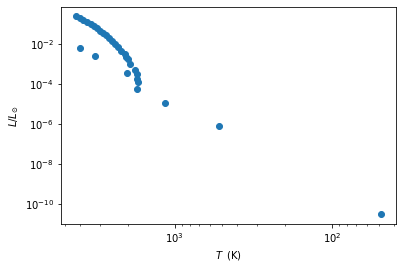

Plotted Hertzsprung-Russell diagram


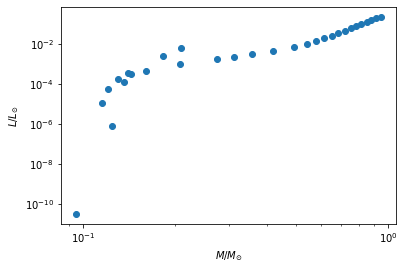

Plotted mass-luminosity relation


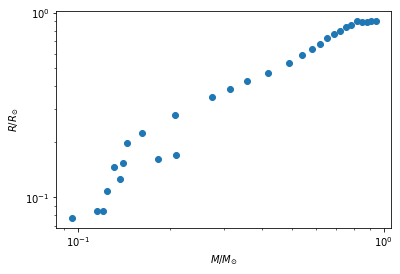

Plotted mass-radius relation
--------------------------------------------------------------------------------
Plotting complete.
Saving results...
Results saved.
--------------------------------------------------------------------------------


In [51]:
Lambda = -1e7
plot_main_sequence(30000, 1e7, 30, 'MS_neg_e7')